In [45]:
import os,sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

sys.path.append("./dataset")
# 数据集类
from mnist import MnistDataset

torch.manual_seed(3)

# 鉴别器

In [46]:
class Discriminator(nn.Module):
    def __init__(self):
        # 初始化PyTorch父类
        super().__init__()

        # 定义神经网络层
        self.model = nn.Sequential(
                        nn.Linear(28*28, 200),
                        nn.Sigmoid(),
                        nn.Linear(200, 1),
                        nn.Sigmoid()
        )

        # 创建损失函数
        self.loss_function = nn.MSELoss()

        # 创建优化器, 使用随机梯度下降
        self.optimiser = torch.optim.SGD(self.parameters(), 
                                            lr=0.01)
        
        # 计数器和进程记录
        self.counter = 0
        self.progress = []
                
    def forward(self,inputs):
        return self.model(inputs)
    
    def train(self, inputs, targets):
        # 计算网络的输出
        outputs = self.model(inputs)
        
        # 计算损失值
        loss = self.loss_function(outputs, targets)
        
        # 每训练10次增加计数器
        if (self.counter % 10 == 0):    self.progress.append(loss.item())

        if (self.counter % 10000 == 0): print("counter = ", self.counter)

        # 归零梯度，反向传播，并更新权重
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        self.counter += 1

        pass
    
    def plot_progress(self):
        plt.scatter(np.arange(1, int(self.counter/10)+1),self.progress,s=10,c="tab:pink",label="Discriminator loss")
        plt.xlabel("time/10") 
        plt.ylabel("loss")
        
        plt.show()
        pass

# 生成器

In [47]:
class Generator(nn.Module):
    def __init__(self):
        # 初始化PyTorch父类
        super().__init__()

        # 定义神经网络层
        self.model = nn.Sequential(
                    nn.Linear(1, 200),
                    nn.Sigmoid(),
                    nn.Linear(200, 28*28),
                    nn.Sigmoid()
        )

        # 创建优化器，使用随机梯度下降
        self.optimiser = torch.optim.SGD(self.parameters(), 
                                            lr=0.01)
        
        # 计数器和进程记录
        self.counter = 0
        self.progress = []

    def forward(self, inputs):
        # 直接运行模型
        return self.model(inputs)
    
    def train(self, D, inputs, targets):
        # 计算网络输出
        g_output = self.forward(inputs)

        # 输入鉴别器
        d_output = D.forward(g_output)

        # 计算损失值
        loss = D.loss_function(d_output, targets)

        # 每训练10次增加计数器
        if (self.counter % 10 == 0):    self.progress.append(loss.item())

        # 归零梯度，反向传播，并更新权重
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        self.counter += 1
    
    def plot_progress(self):
        plt.scatter(np.arange(1, int(self.counter/10)+1),self.progress,s=10,c="tab:pink",label="Generator loss")
        plt.xlabel("time/10") 
        plt.ylabel("loss")
        
        plt.show()
        pass

    def plot_image(self, inputs):
        # 计算网络输出
        g_output = self.forward(inputs)
        g_output = np.array(g_output.detach()).reshape(28,28)
        figure, ax = plt.subplots()
        im = ax.imshow(g_output)
        plt.colorbar(im)
        plt.title('image of Generator')
        plt.show()

    def plot_image6(self, inputs):
        figure, ax = plt.subplots(2,3,figsize=(16,8))
        for i in range(2):
            for j in range(3):
                g_output = self.forward(inputs)
                g_output = np.array(g_output.detach()).reshape(28,28)
                ax[i,j].imshow(g_output,interpolation='none',cmap='Blues')

# 训练网络

In [48]:
# 创建生成器和鉴别器
D = Discriminator()
G = Generator()

# 测试生成器

In [49]:
def generate_random(size=1):
    random_data = torch.rand(size)
    return random_data

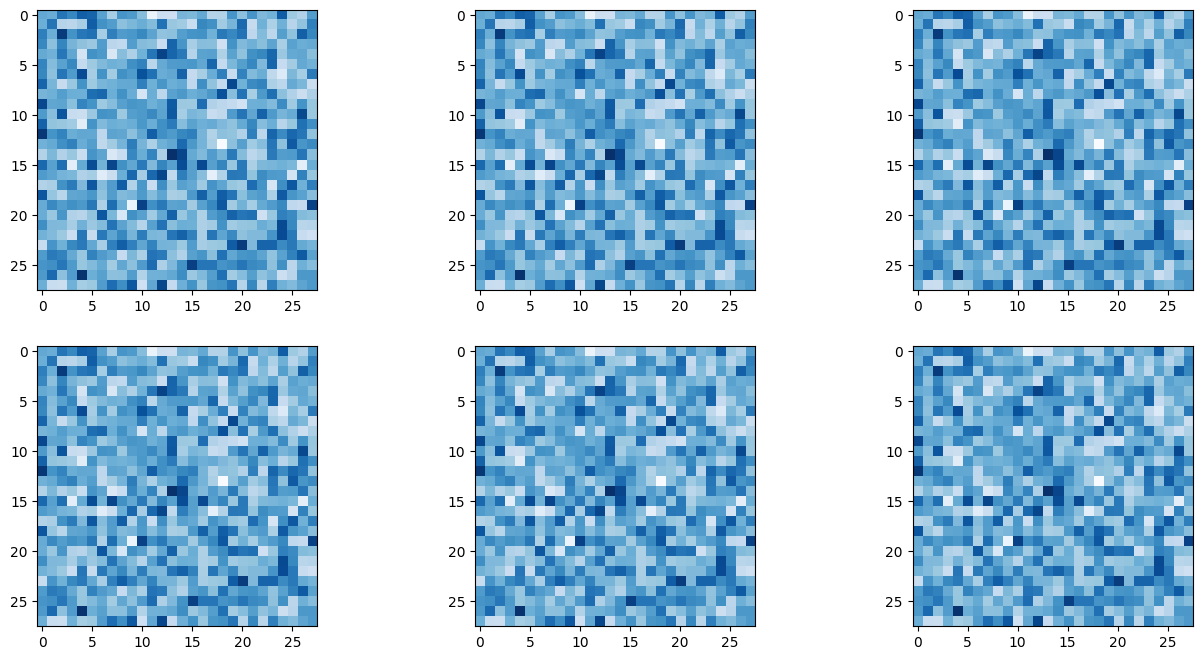

In [50]:
G.plot_image6(generate_random())

# 导入数据集

In [51]:
path = r"./dataset"

filename_images = "train-images-idx3-ubyte"
filename_labels = "train-labels-idx1-ubyte"
filename_images = path+"/"+filename_images
filename_labels = path+"/"+filename_labels


Mnist_train = MnistDataset(filename_images, filename_labels)

dataset_images is existing
dataset_labels is existing


In [52]:
for label, image_values, target in Mnist_train:
    # 正确值
    D.train(image_values, torch.FloatTensor([1.0]))
    # 用生成器生成的数据训练鉴别器（错误 0.0）
    D.train(G.forward(generate_random()).detach(), torch.FloatTensor([0.0]))
    # 用生成器生成的数据训练生成器(正确 1.0）
    G.train(D, generate_random(), torch.FloatTensor([1.0]))

counter =  0
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000


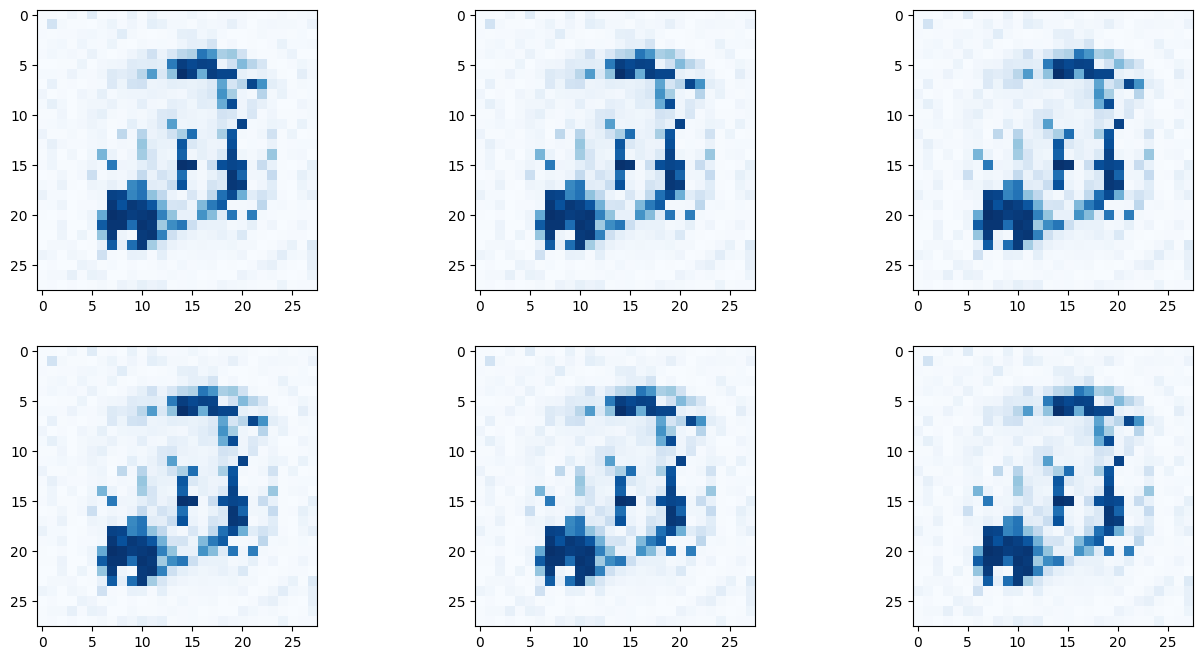

In [53]:
G.plot_image6(generate_random())

# 优化
1、损失函数 
2、激活函数 
3、优化器   